In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os 

import cv2
from collections import defaultdict
from tqdm import tqdm

In [2]:
data = np.load("../AI_HW2_data/mars_no_outliers.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# Try to find unlabeled images

In [5]:
X_train.shape 

(2506, 64, 128)

In [10]:
unlabeled_count = 0
for mask in y_train:
    if len(np.unique(mask)) == 1 and np.unique(mask)[0] == 0:
        unlabeled_count += 1

In [11]:
unlabeled_count

7

In [7]:
np.unique(y_train[0])

array([0., 2.])

In [3]:
X_train.shape 

(2506, 64, 128)

In [4]:
cv2.imread('AI_HW2_data/ai4mars-dataset-merged-0.1/msl/images/edr/NLA_397681398EDR_F0020000AUT_04096M1.JPG').shape

(1024, 1024, 3)

In [7]:
X_train[1][..., np.newaxis].shape

(64, 128, 1)

# Finding crops on source images, using key-points (did not work)

In [8]:
orb = cv2.ORB_create() 

source_keypoints_descriptors = []
print("Extracting keypoints and descriptors from source images...")
for idx, img_name in enumerate(tqdm(os.listdir('../AI_HW2_data/ai4mars-dataset-merged-0.1/msl/images/edr/'), desc="Source Images")):
    if img_name[-3:] == "JPG":
        img = cv2.imread(f"../AI_HW2_data/ai4mars-dataset-merged-0.1/msl/images/edr/{img_name}")
        if len(img.shape) == 2:  
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Преобразуем в RGB
        keypoints, descriptors = orb.detectAndCompute(img, None)
        source_keypoints_descriptors.append((keypoints, descriptors))

Extracting keypoints and descriptors from source images...


Source Images: 100%|██████████████████████| 18130/18130 [04:07<00:00, 73.24it/s]


In [3]:
import cv2
import numpy as np
from collections import defaultdict
from tqdm import tqdm 

def find_crop_position(source_keypoints_descriptors, crops):
    """
    Find the position of the drops among the source images with progress bars.
    
    Parameters:
        source_images_path (list of str): Paths to source images.
        crops (list of np.array): list of crops for search.

    Returns:
        dict: Comparison of the crop with the indexes of the original images and coordinates.
    """
    
    orb = cv2.ORB_create()
    results = {}


    print("Matching crops with source images...")
    for crop_idx, crop in enumerate(tqdm(crops, desc="Crops")):
        if crop.dtype != np.uint8:
            crop = (crop * 255).astype(np.uint8) if crop.max() <= 1 else crop.astype(np.uint8)
        
        
        if crop.shape[:2] == (64, 128) and len(crop.shape) == 2:
            crop = cv2.cvtColor(crop, cv2.COLOR_GRAY2BGR) 
        crop_keypoints, crop_descriptors = orb.detectAndCompute(crop, None)
        best_match = None
        max_matches = 0
        crop_position = None

        for src_idx, (src_keypoints, src_descriptors) in enumerate(source_keypoints_descriptors):
            if src_descriptors is None or crop_descriptors is None:
                continue

            if src_descriptors.dtype != crop_descriptors.dtype:
                src_descriptors = src_descriptors.astype(np.uint8)
                crop_descriptors = crop_descriptors.astype(np.uint8)

            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(crop_descriptors, src_descriptors)
            matches = sorted(matches, key=lambda x: x.distance)

            if len(matches) > max_matches:
                max_matches = len(matches)
                best_match = src_idx

                src_pts = np.float32([crop_keypoints[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
                dst_pts = np.float32([src_keypoints[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

                if len(matches) >= 4:  
                    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
                    if H is not None:
                        h, w = crop.shape[:2]
                        corners = np.float32([[0, 0], [w, 0], [w, h], [0, h]]).reshape(-1, 1, 2)
                        transformed_corners = cv2.perspectiveTransform(corners, H)
                        crop_position = transformed_corners

        results[crop_idx] = {
            'source_image': best_match,
            'matches': max_matches,
            'position': crop_position
        }

    return results


In [10]:
match_results = find_crop_position(source_keypoints_descriptors, X_train)

Matching crops with source images...


Crops: 100%|████████████████████████████████| 2506/2506 [07:03<00:00,  5.91it/s]


In [21]:
import matplotlib.pyplot as plt
import cv2

def visualize_results(results, crops, source_images):
    """
    Visualize crop matching results.

    Parameters:
        results (dict): Matching results containing source_image, matches, and position.
        crops (list of np.array): List of crop images.
        source_images (list of np.array): List of source images.
    """
    # Step 1: Bar plot for matches
    crop_indices = list(results.keys())
    matches = [results[idx]['matches'] for idx in crop_indices]
    
    plt.figure(figsize=(15, 5))
    plt.bar(crop_indices, matches, color='blue')
    plt.title('Number of Matches per Crop')
    plt.xlabel('Crop Index')
    plt.ylabel('Number of Matches')
    plt.show()
    
    # Step 2: Visualize crops on matched source images
    for crop_idx, result in results.items():
        crop = crops[crop_idx]
        source_idx = result['source_image']
        position = result['position']
        
        if source_idx is not None:
            source_image_name = source_images[source_idx]
            print(img_name)
            source_image = cv2.imread(f"../AI_HW2_data/ai4mars-dataset-merged-0.1/msl/images/edr/{img_name}")
            plt.figure(figsize=(10, 5))
            
            # Plot source image
            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY), cmap='gray')
            plt.title(f"Source Image {source_idx}")
            
            # Plot crop
            plt.subplot(1, 2, 2)
            plt.imshow(crop, cmap='gray')
            plt.title(f"Crop {crop_idx} - Matches: {result['matches']}")
            
            if position is not None:
                print(f"Crop {crop_idx} Position on Source {source_idx}: {position}")
            
            plt.show()

# Usage:
# Assume `crops` is a list of crop images and `source_images` is a list of source images



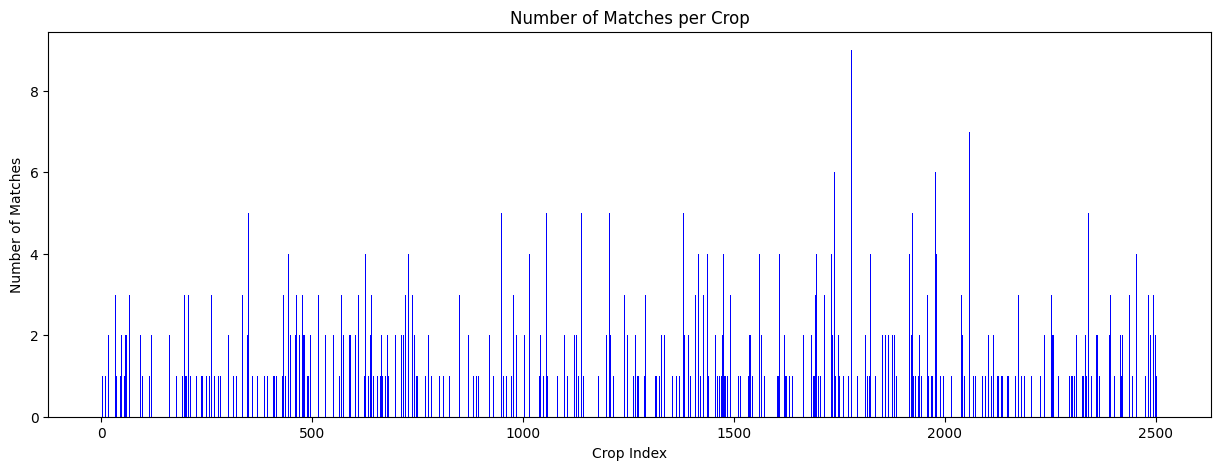

NRB_585342484EDR_F0713370SAPP07612M1.JPG


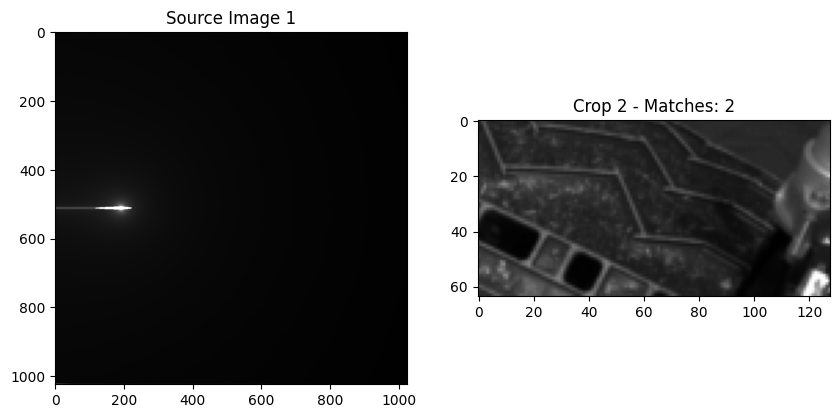

NRB_585342484EDR_F0713370SAPP07612M1.JPG


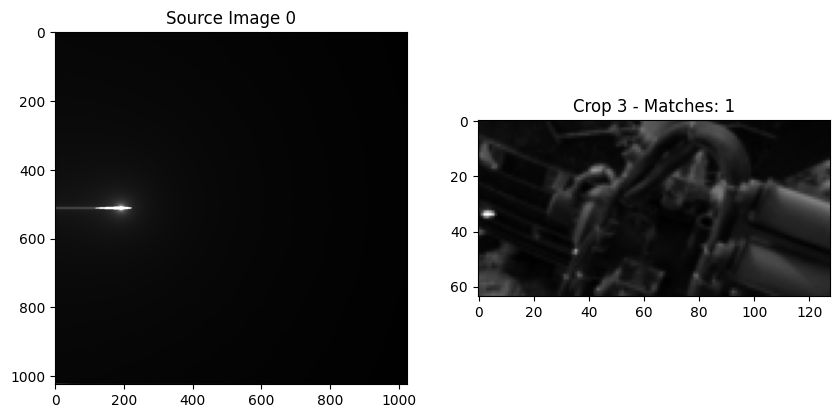

NRB_585342484EDR_F0713370SAPP07612M1.JPG


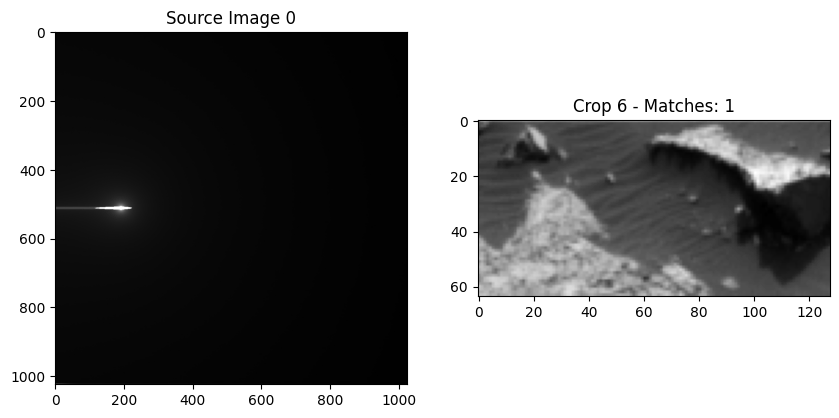

NRB_585342484EDR_F0713370SAPP07612M1.JPG


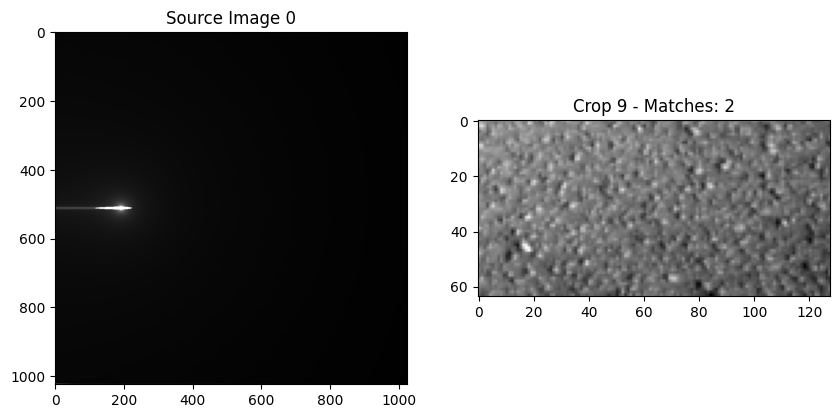

NRB_585342484EDR_F0713370SAPP07612M1.JPG


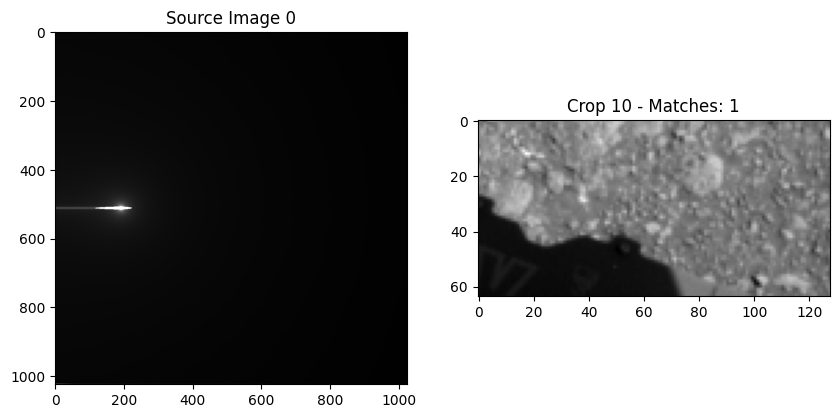

NRB_585342484EDR_F0713370SAPP07612M1.JPG
Crop 14 Position on Source 0: [[[318.9032  720.21954]]

 [[318.9032  720.21954]]

 [[318.9032  720.21954]]

 [[318.9032  720.21954]]]


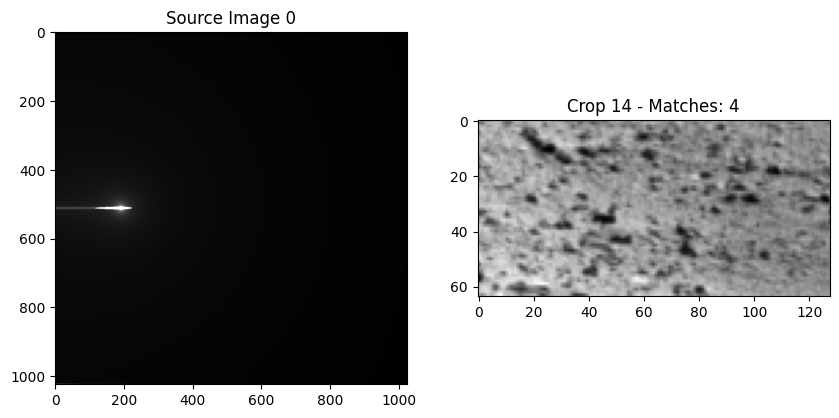

NRB_585342484EDR_F0713370SAPP07612M1.JPG


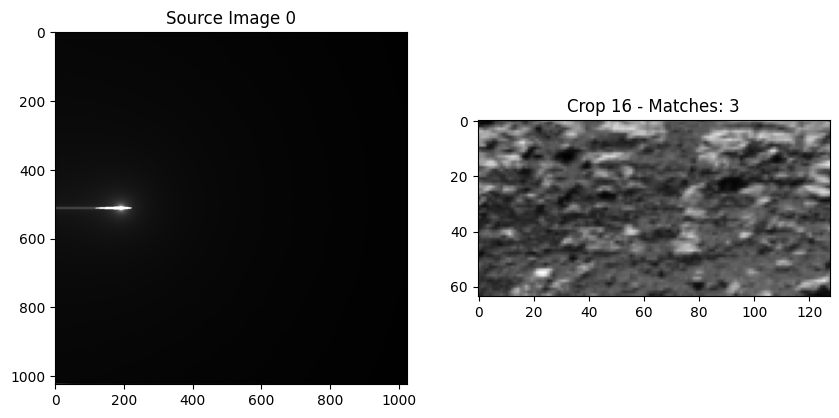

NRB_585342484EDR_F0713370SAPP07612M1.JPG


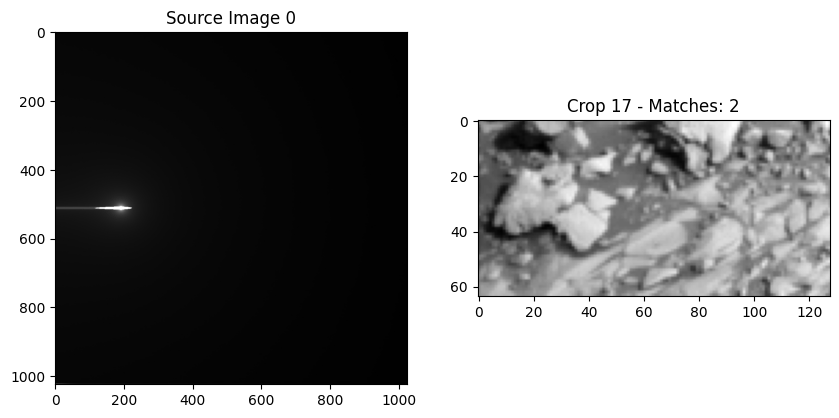

NRB_585342484EDR_F0713370SAPP07612M1.JPG


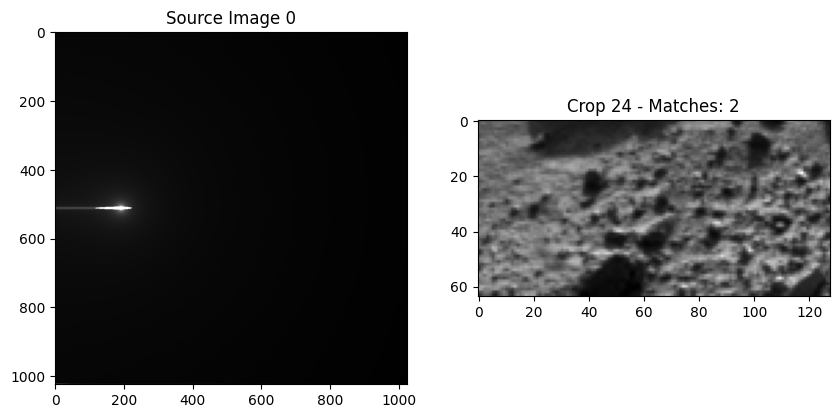

NRB_585342484EDR_F0713370SAPP07612M1.JPG


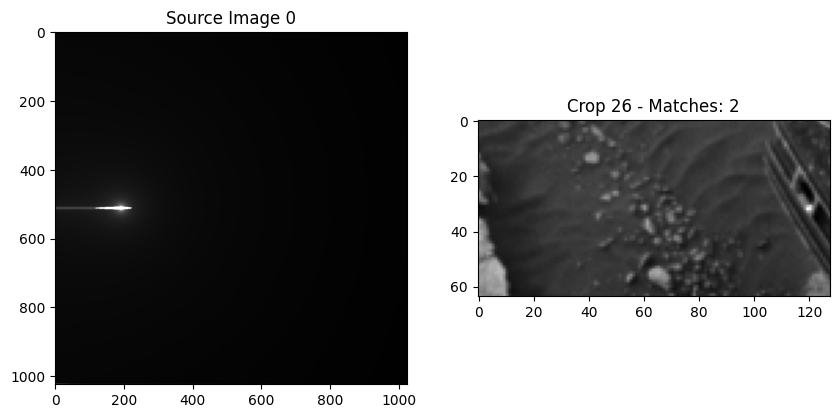

NRB_585342484EDR_F0713370SAPP07612M1.JPG


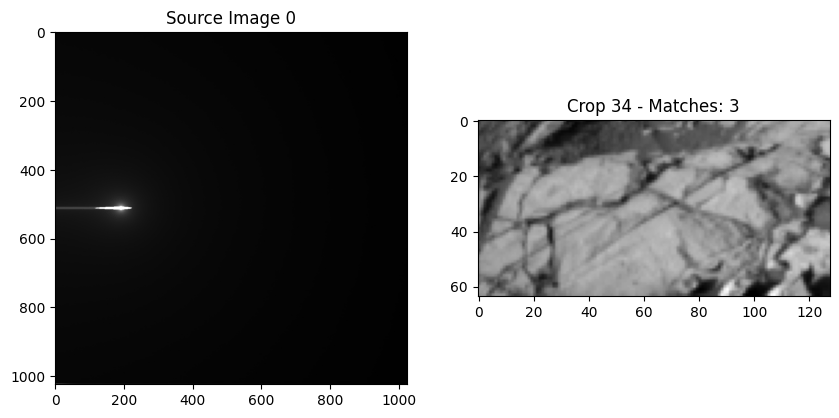

NRB_585342484EDR_F0713370SAPP07612M1.JPG


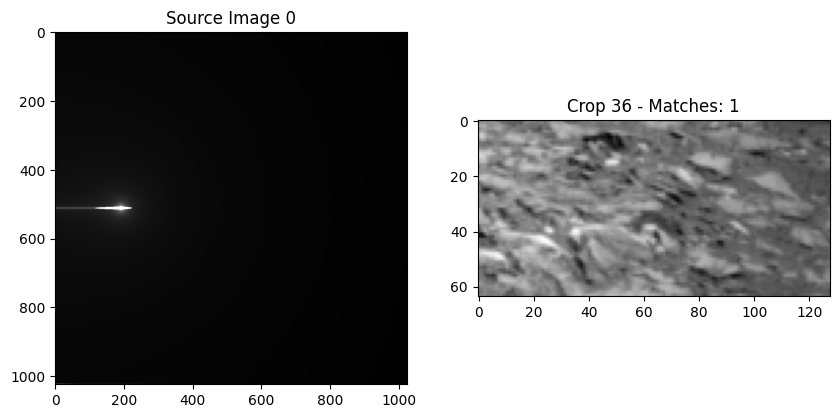

NRB_585342484EDR_F0713370SAPP07612M1.JPG


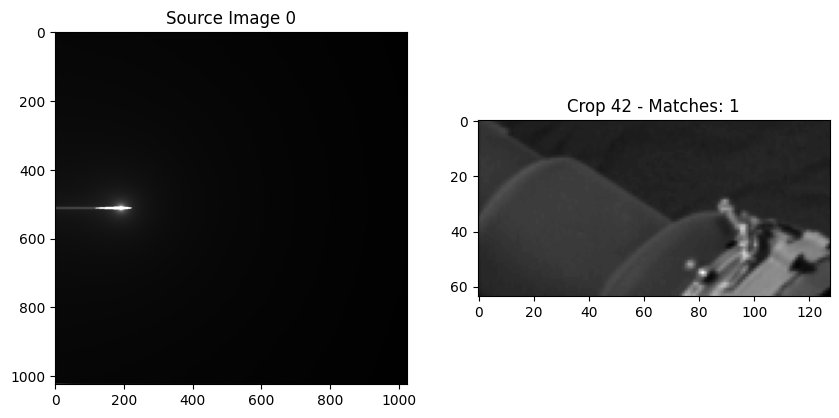

NRB_585342484EDR_F0713370SAPP07612M1.JPG


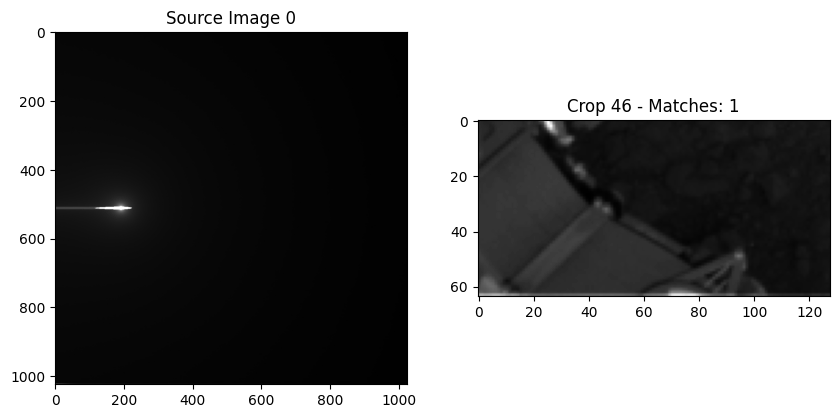

NRB_585342484EDR_F0713370SAPP07612M1.JPG


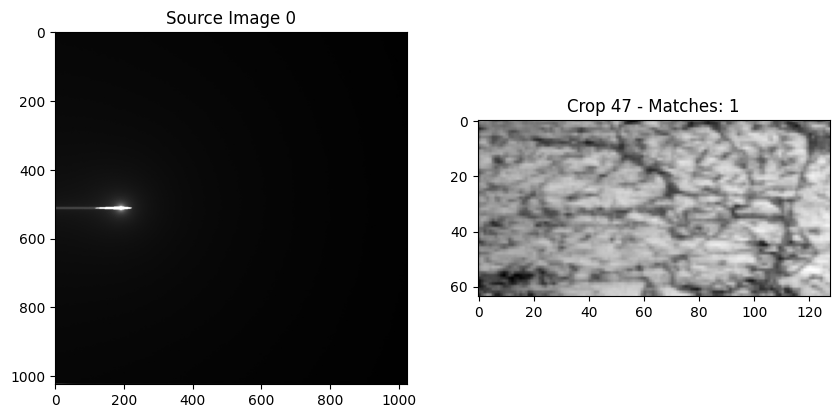

NRB_585342484EDR_F0713370SAPP07612M1.JPG


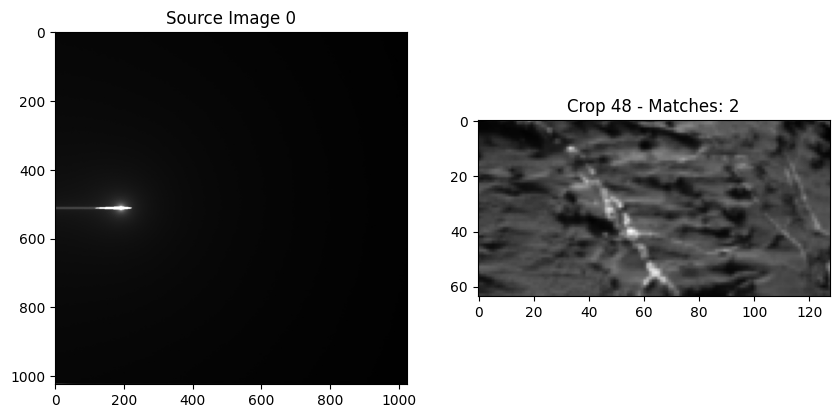

NRB_585342484EDR_F0713370SAPP07612M1.JPG


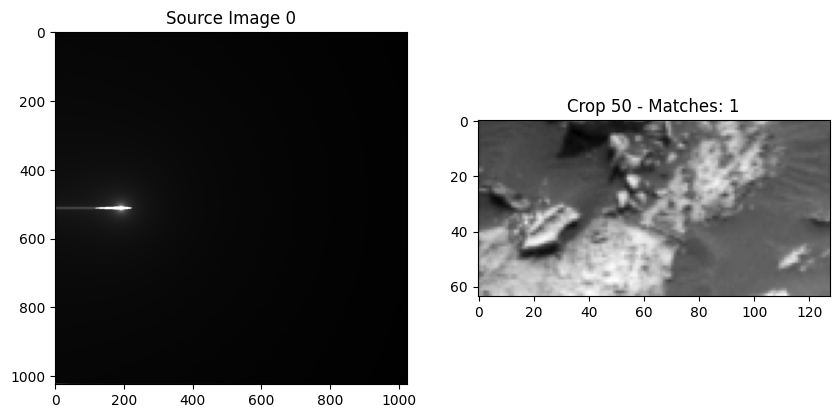

NRB_585342484EDR_F0713370SAPP07612M1.JPG


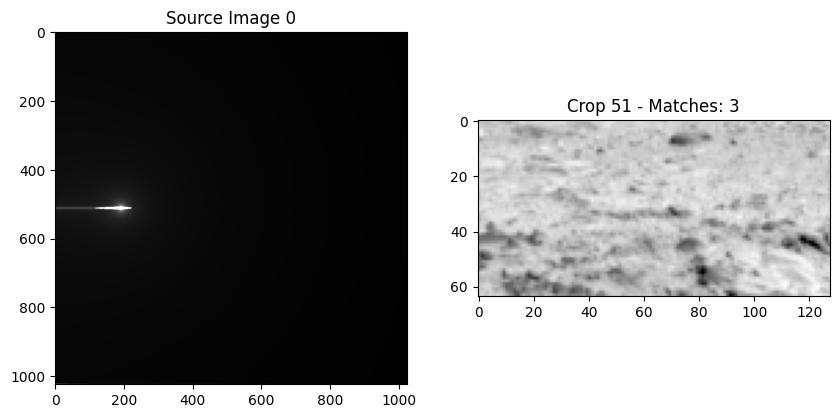

NRB_585342484EDR_F0713370SAPP07612M1.JPG


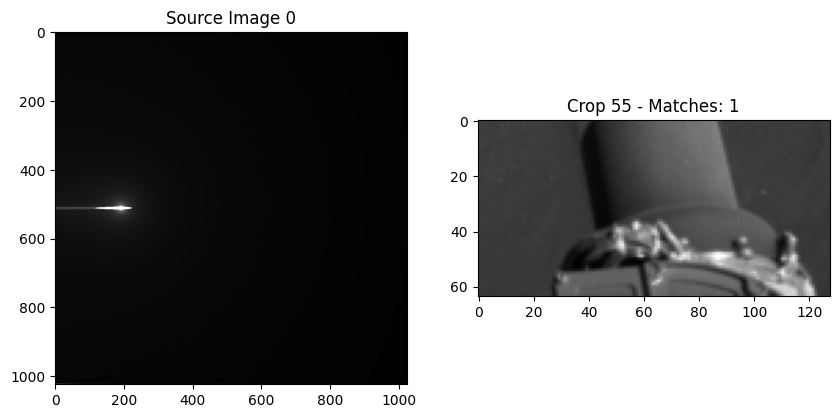

NRB_585342484EDR_F0713370SAPP07612M1.JPG


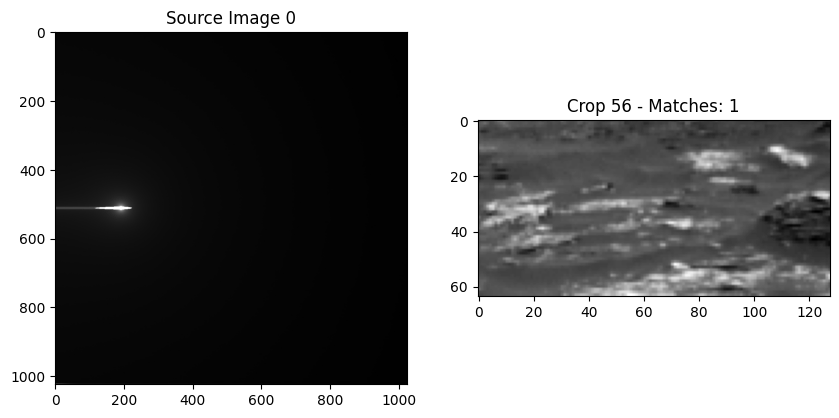

NRB_585342484EDR_F0713370SAPP07612M1.JPG


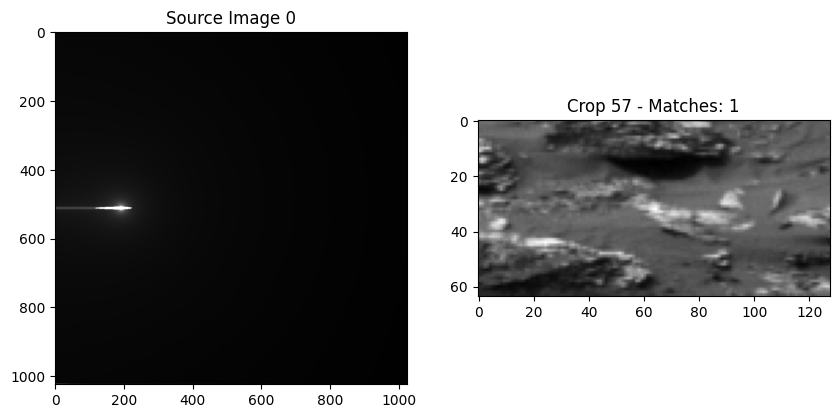

NRB_585342484EDR_F0713370SAPP07612M1.JPG


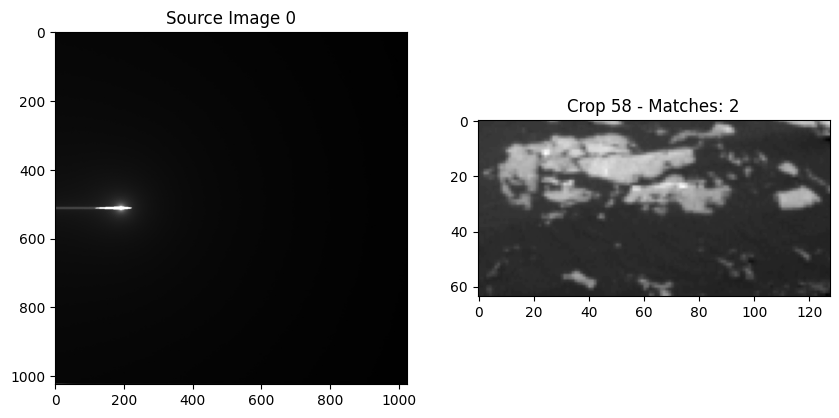

NRB_585342484EDR_F0713370SAPP07612M1.JPG


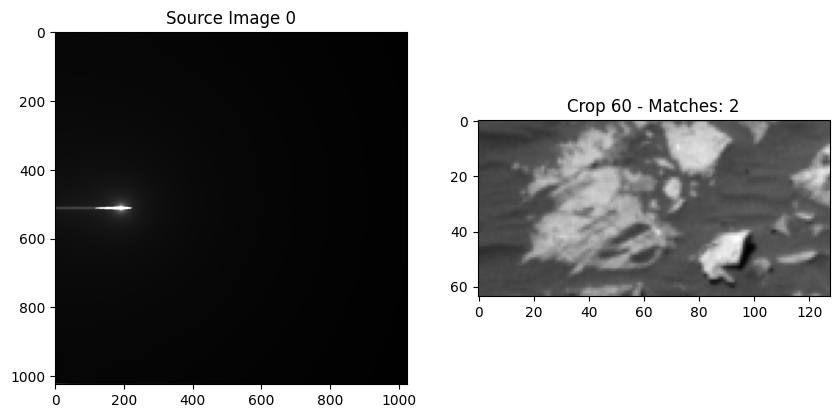

NRB_585342484EDR_F0713370SAPP07612M1.JPG


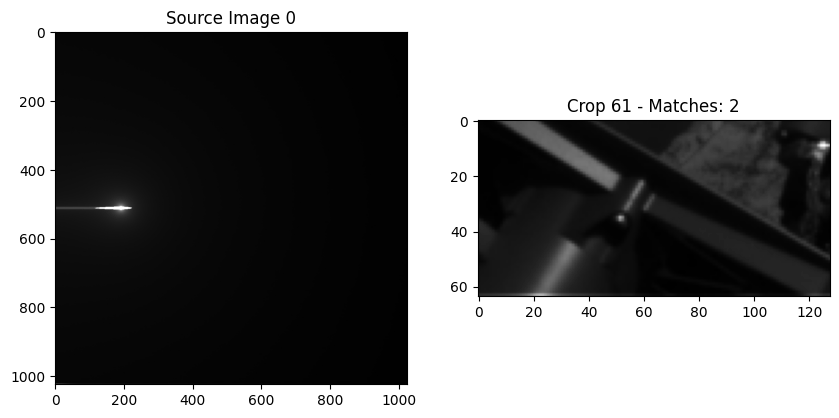

NRB_585342484EDR_F0713370SAPP07612M1.JPG


KeyboardInterrupt: 

In [22]:
visualize_results(match_results, X_train, os.listdir('../AI_HW2_data/ai4mars-dataset-merged-0.1/msl/images/edr/'))

In [54]:
images_names = os.listdir('AI_HW2_data/ai4mars-dataset-merged-0.1/msl/images/edr/')
source_img = cv2.imread(f"AI_HW2_data/ai4mars-dataset-merged-0.1/msl/images/edr/{images_names[1]}")


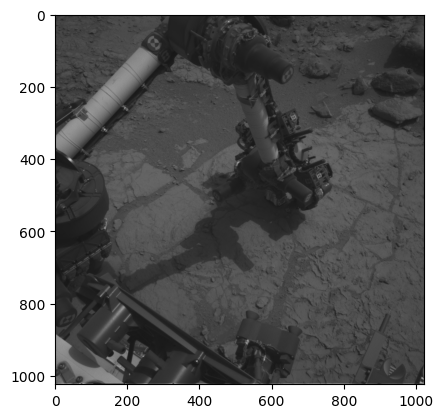

In [55]:
plt.imshow(source_img+20)

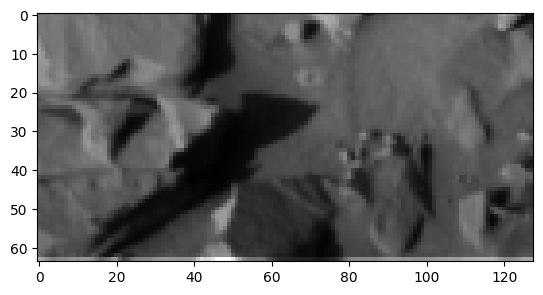

In [53]:
plt.imshow(X_train[113], cmap='gray')

In [47]:
def get_valid_match_positions(results):
    """
    Extract match positions where position is not None.

    Parameters:
        results (dict): The results dictionary containing 'source_image', 'matches', and 'position'.

    Returns:
        list: List of tuples containing (crop_index, source_image_index, position)
    """
    valid_match_positions = []

    for crop_idx, result in results.items():
        position = result['position']
        
        if position is not None:
            source_idx = result['source_image']
            # Store valid match information (crop_index, source_image_index, position)
            valid_match_positions.append((crop_idx, source_idx, position))
    
    return valid_match_positions

In [48]:
match_results_valid = get_valid_match_positions(match_results)

In [56]:
len(match_results_valid) 

73